In [272]:
######################
##  Library Imports
######################
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
# mpl.rcParams['figure.figsize']    = [12, 7]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
# mpl.rcParams['axes.labelsize']    = 6
mpl.rcParams['font.size']         = 16
mpl.rcParams['lines.linewidth']   = 1.75
# mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import pandas as pd
# import multiprocessing as mprocs
# from threading import Thread
# from subprocess import Popen, PIPE
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from numba import jit, njit, prange
import itertools 
# from scipy.stats import linregress
# from numpy.polynomial.polynomial import polyfit

from functions import open_file, read_in_triads

In [202]:
@njit
def normalize_time_order(order, kmin):

    ## Get params
    num_t_steps = order.shape[0]
    num_osc     = order.shape[1]
    
    norm_order = np.ones((num_t_steps, num_osc)) * np.complex(0.0, 0.0)
    for t in range(num_t_steps):
        for k in range(kmin, num_osc):
            norm_order[t, k] = order[t, k] / np.absolute(order[t, k])

    return norm_order


@njit
def compute_time_order(order, kmin):

    ## Get params
    num_t_steps = order.shape[0]
    num_osc     = order.shape[1]

    tmp_time_order = np.ones((num_osc, )) * np.complex(0.0, 0.0)   
    time_order     = np.ones((num_t_steps, num_osc)) * np.complex(0.0, 0.0) 

    t_count = 1
    for t in range(num_t_steps):
        for k in range(kmin, num_osc):
            tmp_time_order[k] += np.exp(np.complex(0.0, 1.0) * np.angle(order[t, k]))
            time_order[t, k] = tmp_time_order[k] / t_count
        t_count += 1

    return time_order

In [203]:
def read_in_triads(file):

    if 'Triads' in list(file.keys()):
        triad  = file['Triads']
        
        # Reshape triads
        tdims  = triad.attrs['Triad_Dims']
        triads = np.array(np.reshape(triad, np.append(triad.shape[0], tdims[0, :])))
    else: 
        print("Triads dataset does not exist!")

    return triads

In [204]:
def triad_histogram(triads, nbins):
    counts, bins = np.histogram(np.extract(triads != -10.0, triads), bins = nbins, density = True, range = (0.0, 2.0 * np.pi))
    bin_centres = (bins[1:] + bins[:-1]) * 0.5
    
    return counts, bin_centres

def histogram(triads, nbins):
    counts, bins = np.histogram(triads, bins = nbins, density = True, range = (0.0, 2.0 * np.pi))
    bin_centres = (bins[1:] + bins[:-1]) * 0.5
    
    return counts, bin_centres

In [205]:
#########################
##  Get Input Parameters
#########################
k0    = 1
N     = [256]
alpha = [1.5]
beta  = 0.0
u0    = 'RANDOM'
iters = int(1e5)
trans = int(1e5)

kmin    = k0 + 1
num_osc = int(N[0] / 2) + 1
kmax    = int(N[0] / 2)

######################
##  Input & Output Dir
######################
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/PhaseOrder/Investigate"


## Open file
file = open_file(alpha[0], N[0], k0, beta, u0, iters, trans, input_dir)

a = 1.500 || Filename: /work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/RESULTS_N[256]_k0[1]_ALPHA[1.500]_BETA[0.000]_u0[RANDOM]/SolverData_ITERS[100000]_TRANS[10000].h5


In [206]:
## Read in data
time    = file["Time"][:]
amps    = file["Amps"][:]
phases  = file["Phases"][:, :]
order   = file["PhaseShiftScaleOrderParam"][:, :]
solver_time_order = file["ThetaTimeScaleOrderParam"][:, :]
R_k_avg = file["R_k_avg"][:]
triads_solver = read_in_triads(file)
## Close file
file.close()

In [207]:
## Compute time order
time_order = compute_time_order(order, k0 + 1)

## Compute normed time order
normed_order = normalize_time_order(order, k0 + 1)

## Compute time order
normed_time_order = compute_time_order(normed_order, k0 + 1)

## Compute R_k
r_k = np.absolute(time_order[-1, :])
normed_r_k = np.absolute(normed_time_order[-1, :])

In [192]:
Theta_k = np.angle(time_order[-1, :])
Normed_Theta_k = np.angle(normed_time_order[-1, :])

In [193]:
@njit
def triad_order_sync_phases(phases, kmin, kmax):
    
    triad_order = np.ones(phases.shape) * np.complex(0.0, 0.0)
    for t in range(phases.shape[0]):
        for k in range(kmin, kmax + 1):
            triad = np.complex(0.0, 0.0)
            for k1 in range(-kmax + k, kmax + 1):
                if np.absolute(k1) >= kmin and np.absolute(k - k1) >= kmin:
                    if k1 < 0 and k - k1 > 0:
                        triad += amps[np.absolute(k1)] * amps[np.absolute(k - k1)] * np.exp(np.complex(0.0, 1.0) * (-phases[t, np.absolute(k1)] + phases[t, np.absolute(k - k1)] - phases[t, k]))
                    if k1 > 0 and k - k1 < 0:
                        triad += amps[np.absolute(k1)] * amps[np.absolute(k - k1)] * np.exp(np.complex(0.0, 1.0) * (phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k]))
                    elif k1 > 0 and k - k1 > 0:
                        triad += amps[np.absolute(k1)] * amps[np.absolute(k - k1)] * np.exp(np.complex(0.0, 1.0) * (phases[t, np.absolute(k1)] + phases[t, np.absolute(k - k1)] - phases[t, k]))
            triad_order[t, k] = np.complex(0.0, 1.0) * triad
            
    return triad_order

In [194]:
# @njit
def extract_triad_sync_phases(phases, kmin, kmax, k_star, t):
    
    triads = []
    for t in range(phases.shape[0]):
        for k in range(kmin, kmax + 1):
            for k1 in range(-kmax + k, kmax + 1):
                if np.absolute(k1) >= kmin and np.absolute(k - k1) >= kmin:
                    if k1 < 0 and k - k1 > 0:
                        if np.absolute(k1) == k_star or np.absolute(k - k1) == k_star:
                            triads.append(-phases[t, np.absolute(k1)] + phases[t, np.absolute(k - k1)] - phases[t, k])
                    if k1 > 0 and k - k1 < 0:
                        if np.absolute(k1) == k_star or np.absolute(k - k1) == k_star:
                            triads.append(phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k])
                    elif k1 > 0 and k - k1 > 0:
                        if np.absolute(k1) == k_star or np.absolute(k - k1) == k_star:
                            triads.append(phases[t, np.absolute(k1)] + phases[t, np.absolute(k - k1)] - phases[t, k])
            
    return triads

In [195]:
%%time 
triad_order = triad_order_sync_phases(phases, kmin, kmax)

CPU times: user 27.9 s, sys: 81.2 ms, total: 28 s
Wall time: 27.9 s


In [196]:
%%time
triad_time_order = compute_time_order(triad_order, k0 + 1)

CPU times: user 257 ms, sys: 24.8 ms, total: 281 ms
Wall time: 279 ms


In [197]:
for i in range(phases.shape[0]):
    print(np.linalg.norm(np.absolute(time_order[i, :]) - np.absolute(triad_time_order[i, :])))
# np.sign(-1 * (3 - (-1)))

7.021666937153402e-16
2.646201207905526e-14
2.3629581786078907e-14
8.551740081109417e-14
6.453702693729002e-14
4.41363945493323e-14
3.9337509983509304e-14
4.2673865794763347e-14
3.856430232963844e-14
3.197356778271719e-14
2.7027418418612757e-14
2.482051563765011e-14
2.353983732669427e-14
2.2106022247909826e-14
2.084296930386252e-14
1.9392479246726786e-14
1.8182249712317738e-14
1.71171025921618e-14
1.5289054022940164e-14
1.4248271418064392e-14
1.3011778621239414e-14
1.1773836986562342e-14
1.1250016510272155e-14
1.0914683808522208e-14
1.049505810538652e-14
1.0596306703648014e-14
1.0932499855100732e-14
1.0965595310782286e-14
1.0437065248023125e-14
1.0365567203182389e-14
1.0114702527234223e-14
1.0223405269259426e-14
1.0196585952306425e-14
1.0013273502793652e-14
9.995678378575186e-15
9.768582625566567e-15
1.1442074040686415e-14
1.1217339568123792e-14
1.0863179140583375e-14
1.081107282932721e-14
1.1069778182671955e-14
1.087495366105138e-14
1.0755428804686002e-14
1.0598024147628876e-14
1.0492

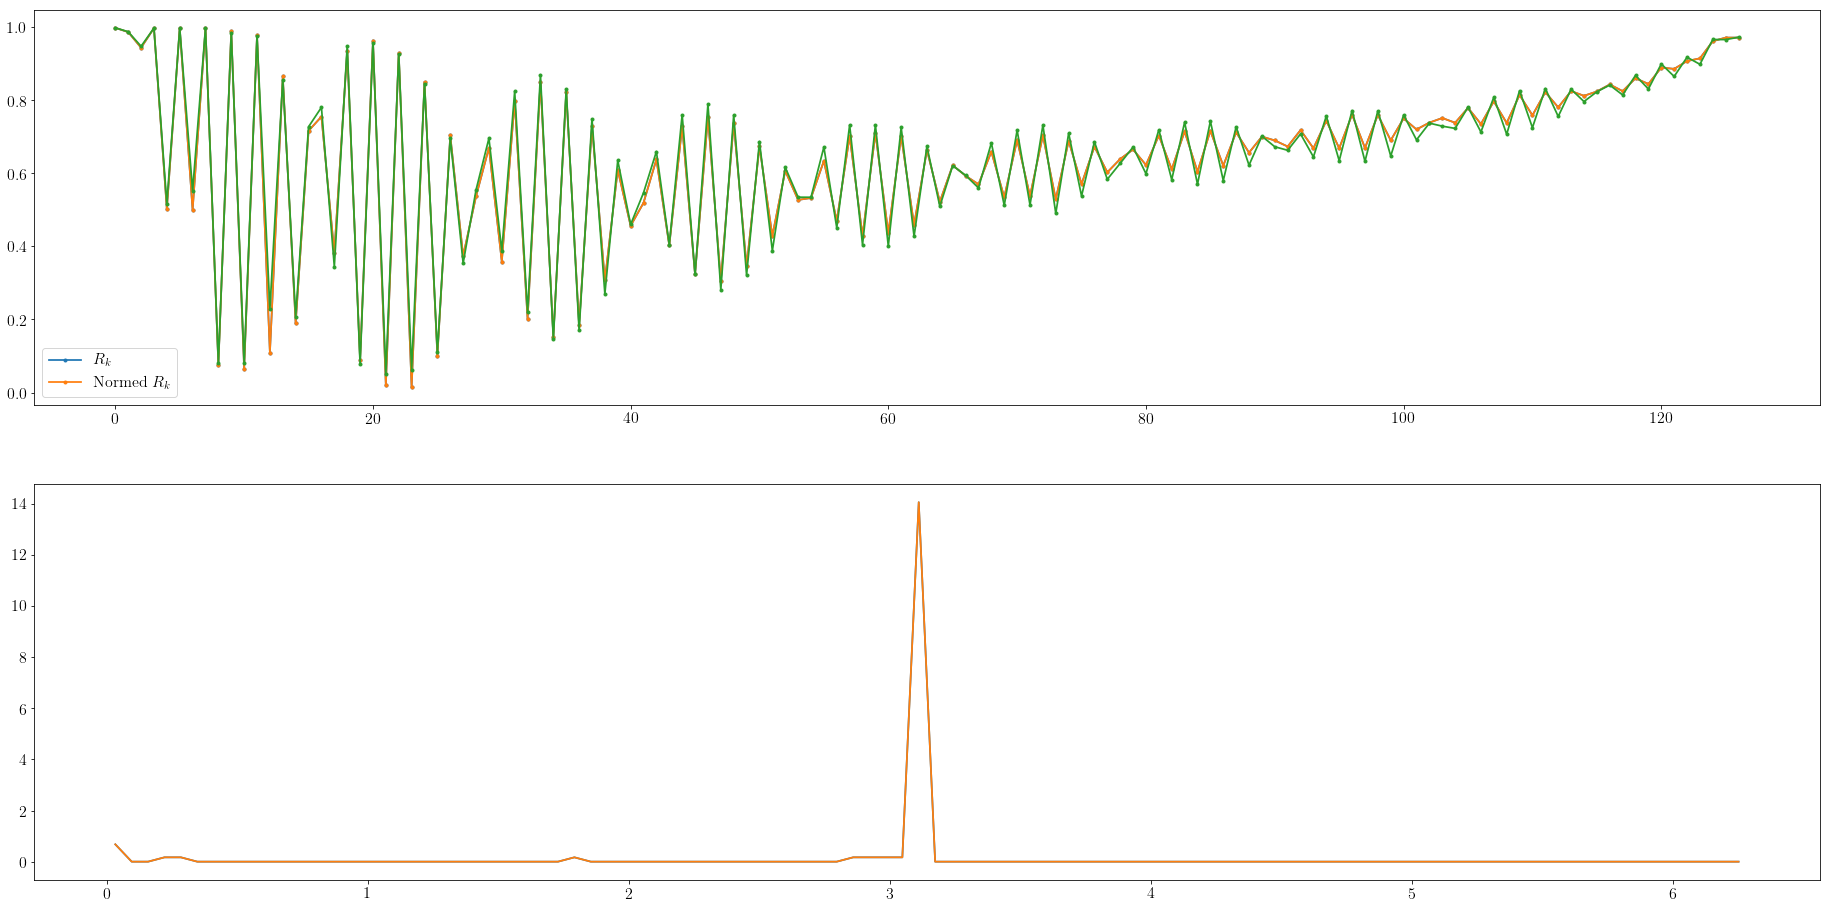

In [137]:
fig = plt.figure(figsize = (32, 16), tight_layout = False)
gs  = GridSpec(2, 1) 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(r_k[k0 + 1:], '.-')
ax1.plot(np.absolute(triad_time_order[-1, k0 + 1:]), '.-')
ax1.plot(R_k_avg[k0 + 1:], '.-')
ax1.legend([r"$R_k$", r"Normed $R_k$"])

ax2 = fig.add_subplot(gs[1, 0])
pdf, centres = histogram(Theta_k[k0 + 1:], 100)
ax2.plot(centres, pdf)
pdf, centres = histogram(np.angle(triad_time_order[-1, k0 + 1:]), 100)
ax2.plot(centres, pdf)
ax1.legend([r"$R_k$", r"Normed $R_k$"])
plt.show()

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1., 23.,  6.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

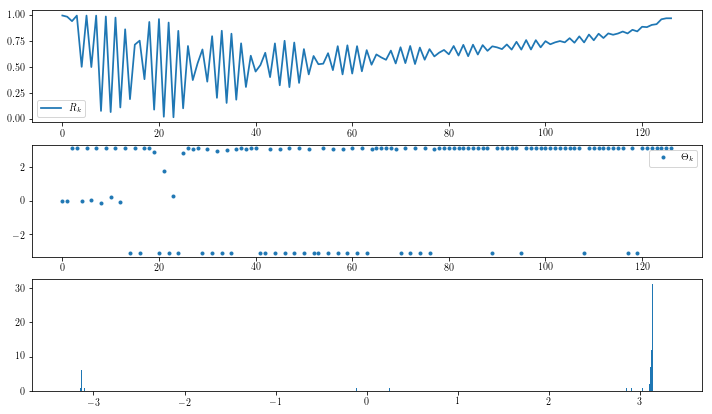

In [9]:
# print(R_k_avg)
fig = plt.figure(figsize = (12, 7), tight_layout = False)
gs  = GridSpec(3, 1) 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(r_k[k0 + 1:])
# plt.plot(normed_r_k[k0 + 1:], '--')
# plt.plot(R_k_avg[k0 + 1:], '.')
# plt.ylim(0.9, 1.1)
ax1.legend([r"$R_k$", r"Normed $R_k$", r"$\langle R_k \rangle$"])


ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(Theta_k[k0 + 1:], '.')
# plt.plot(Normed_Theta_k[k0 + 1:], 'o')
ax2.set_ylim(-np.pi-0.2, np.pi + 0.2)
ax2.legend([r"$\Theta_k$", r"Normed $\Theta_k$"])


ax3 = fig.add_subplot(gs[2, 0])
ax3.hist(Theta_k[k0 + 1:], 1000, range = (-np.pi-.2, np.pi+.2))
# plt.savefig(output_dir + "/KuramotoParam_N[VARIED]_ALPHA[1.5]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')


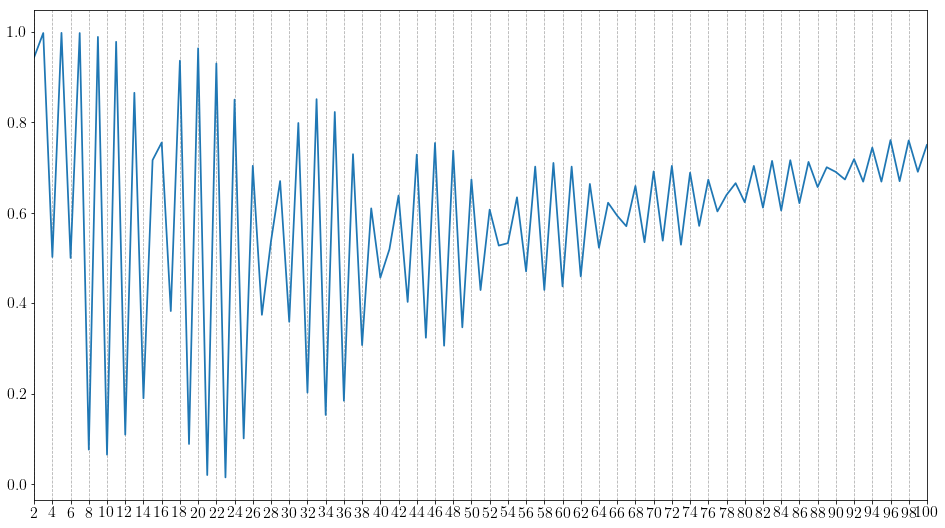

In [179]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
plt.plot(r_k[k0 + 1:])
plt.xlim(k0 + 1, 100)
plt.grid(True, which = 'both', axis = 'x', linestyle = '--')
plt.xticks(np.arange(k0 + 1, 101, 2))
plt.savefig(output_dir + "/R_k_N[VARIED]_ALPHA[1.5]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')

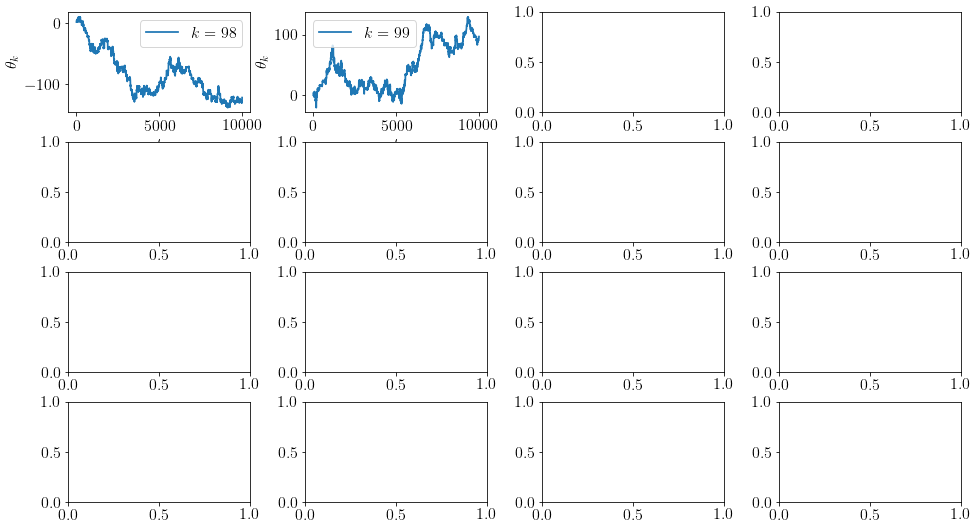

In [180]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 100)):    
    ax[count].plot(np.unwrap(np.angle(order[:, k])))
#     ax[count].plot(np.mod(np.angle(order[:, k]) + np.pi/2, 2.0 * np.pi) - np.pi/2)
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\theta_k$")
    ax[count].legend(["$k = {}$".format(k)])
#     ax[count].set_ylim(-np.pi/2-0.25, 3.0*np.pi/2 + 0.25)
#     ax[count].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
#     ax[count].set_yticklabels([r"$-\pi$", r"$- \frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
    
    if count == 15:
        plt.savefig(output_dir + "/THETA_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
        for i in range(xg * yg):
            ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)

plt.show()
plt.close()

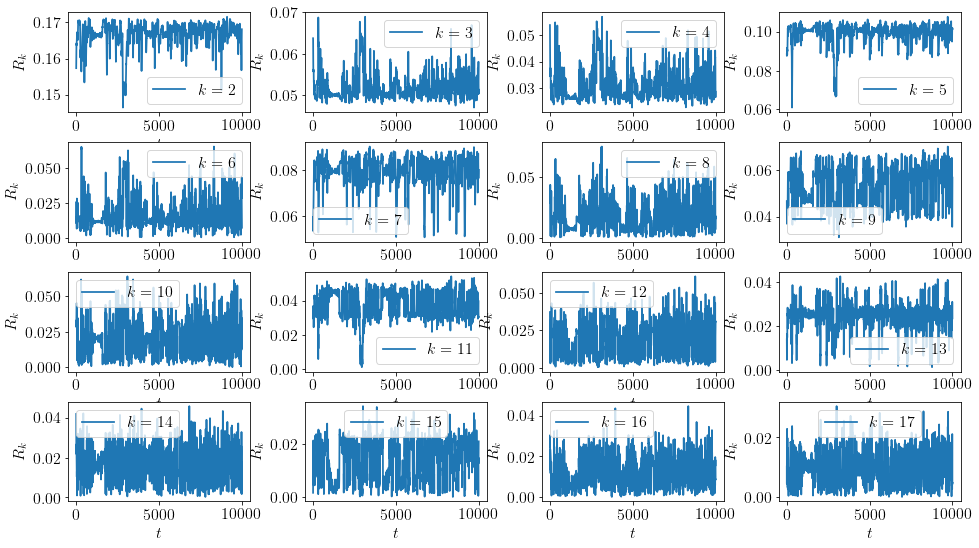

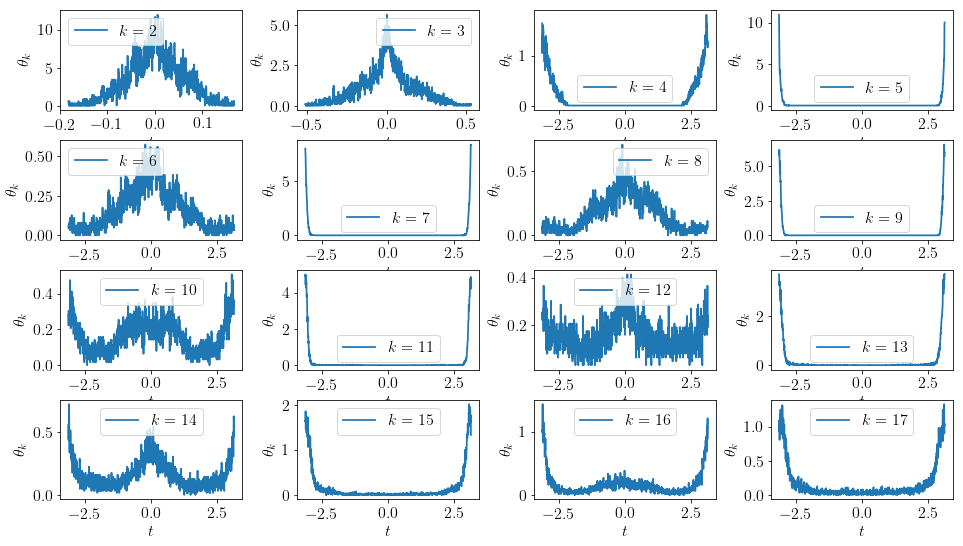

In [238]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 18)):    
    ax[count].plot(np.absolute(order[:, k]))
#     ax[count].plot(np.absolute(normed_time_order[:, k]), '--')
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\tilda{R}_k$")
    ax[count].legend(["$k = {}$".format(k)])
#     ax[count].set_yscale('log')
#     ax[count].set_ylim(0, 1)
#     ax[count].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
#     ax[count].set_yticklabels([r"$-\pi$", r"$- \frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
    
#     if count == 15:
#         plt.savefig(output_dir + "/Rtilda_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
#         for i in range(xg * yg):
#             ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)

fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j])) 
count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 18)):    
#     ax[count].plot(np.unwrap(np.angle(order[:, k])))
    counts, bins = np.histogram(np.angle(order[:, k]), bins = 1000, density = False)
    bin_cents = (bins[1:] + bins[:-1]) * 0.5
    pdf = counts / (np.sum(counts) * (bins[1] - bins[0]))
    ax[count].plot(bin_cents, pdf)
#     ax[count].plot(np.mod(np.angle(order[:, k]) + np.pi/2, 2.0 * np.pi) - np.pi/2)
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\theta_k$")
    ax[count].legend(["$k = {}$".format(k)])
#     ax[count].set_ylim(-np.pi/2-0.25, 3.0*np.pi/2 + 0.25)
#     ax[count].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
#     ax[count].set_yticklabels([r"$-\pi$", r"$- \frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
    
#     if count == 15:
#         plt.savefig(output_dir + "/THETA_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
#         for i in range(xg * yg):
#             ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)
plt.show()
plt.close()

In [198]:
kk = 8
minarg = np.where(np.absolute(order[:, kk]) == np.amin(np.absolute(order[:, kk])))
print(minarg)

(array([5810]),)


In [199]:
triads_k = extract_triad_sync_phases(phases, kmin, kmax, kk, minarg[0])

(array([7547]),)


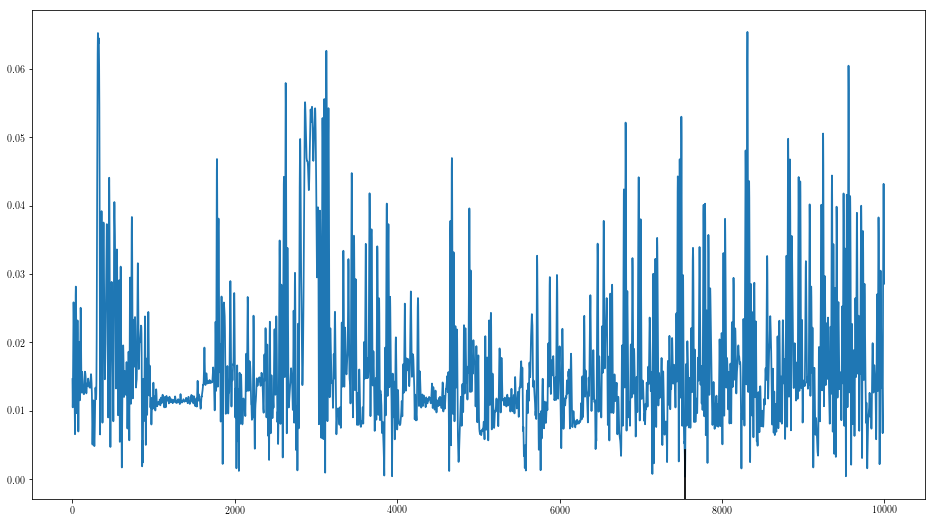

In [16]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
gs  = GridSpec(1, 1, hspace = 0.3, wspace = 0.3)  
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(np.absolute(order[:, 6]))


minarg = np.where(np.absolute(order[:, 6]) == np.amin(np.absolute(order[:, 6])))
print(minarg)
ax1.axvline(x = minarg[0], ymin = 0.0, ymax = 0.1, color = 'black')

plt.show()

In [17]:
def extract_all_triads_all_k(phases, k_star, kmin, kmax, t_star, full = False):
    
    triads_non_ordered_k = list()
    
    if full == True:
        for t in range(phases.shape[0]):
            for k in range(kmin, kmax + 1):
                for k1 in range(-kmax + k, kmax + 1):

                    if (k == k_star) or (np.absolute(k1) == k_star) or (np.absolute(k - k1) == k_star):
                        if k - k1 <= -kmin:
                            if k1 <= -kmin and k1 >= -kmax:
                                triads_non_ordered_k.append(-phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k])
                            if k1 >=  kmin and k1 <= kmax:
                                triads_non_ordered_k.append(phases[t, k1] - phases[t, np.absolute(k - k1)] - phases[t, k])
                        elif k - k1 >= kmin:
                            if k1 <= -kmin and k1 >= -kmax:
                                triads_non_ordered_k.append(-phases[t, np.absolute(k1)] + phases[t, k - k1] - phases[t, k])
                            if k1 >=  kmin and k1 <= kmax:
                                triads_non_ordered_k.append(phases[t, k1] + phases[t, k - k1] - phases[t, k])
                    else:
                        continue
    else:
        for k in range(kmin, kmax + 1):
            for k1 in range(-kmax + k, kmax + 1):

                if (k == k_star) or (np.absolute(k1) == k_star) or (np.absolute(k - k1) == k_star):
                    if k - k1 <= -kmin:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_non_ordered_k.append(-phases[t_star, np.absolute(k1)] - phases[t_star, np.absolute(k - k1)] - phases[t_star, k])
                        if k1 >=  kmin and k1 <= kmax:
                            triads_non_ordered_k.append(phases[t_star, k1] - phases[t_star, np.absolute(k - k1)] - phases[t_star, k])
                    elif k - k1 >= kmin:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_non_ordered_k.append(-phases[t_star, np.absolute(k1)] + phases[t_star, k - k1] - phases[t_star, k])
                        if k1 >=  kmin and k1 <= kmax:
                            triads_non_ordered_k.append(phases[t_star, k1] + phases[t, k - k1] - phases[t, k])
                else:
                    continue
                   
    return triads_non_ordered_k

In [18]:
tirads_k = extract_all_triads_all_k(phases, minarg[0], kmin, kmax, 10, True)

NameError: name 'triads_k' is not defined

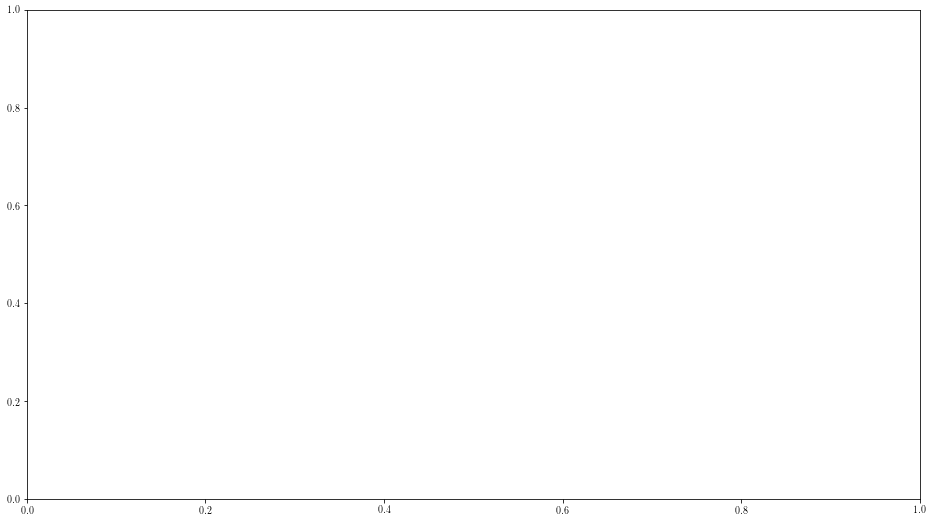

In [19]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
gs  = GridSpec(1, 1, hspace = 0.3, wspace = 0.3)  
ax1 = fig.add_subplot(gs[0, 0])

counts, bins = np.histogram(np.extract(triads_k != -10.0, triads_k), bins = 1000, density = True, range = (0.0 - 0.5, 2.0 * np.pi + 0.5))
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)

NameError: name 'triads_all' is not defined

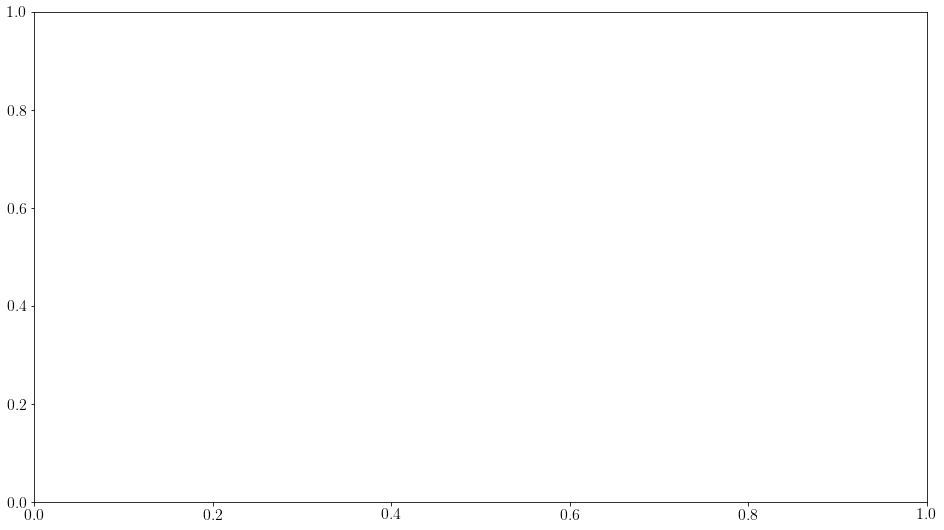

In [57]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
gs  = GridSpec(1, 1, hspace = 0.3, wspace = 0.3)  
ax1 = fig.add_subplot(gs[0, 0])

counts, bins = np.histogram(np.extract(triads_all != -10.0, triads_all), bins = 1000, density = True, range = (0.0 - 0.5, 2.0 * np.pi + 0.5))
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)
counts, bins = np.histogram(np.extract(triads_solver != -10.0, triads_solver), bins = 1000, density = True, range = (0.0 - 0.5, 2.0 * np.pi + 0.5))
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)
ax1.legend([r"Py", r"Solver"])
plt.show()

In [405]:
## Examine the tirads at the min
from functions import compute_current_triads, compute_triads_all

In [ ]:
triads_all, _, _ = compute_triads_all(phases, kmin, kmax)
triads, _, _ = compute_current_triads(phases[minarg[0], :][0], kmin, kmax)

In [411]:
def extract_triads_k(triads, k_star, kmin, kmax, full = False):
    
    k_triads = []
    
    if full == True:
        for t in range(triads.shape[0]):    
            for k in range(kmin, kmax + 1):
                for k1 in range(kmin, int(k/2) + 1):
                    if (k == k_star) or (k1 == k_star) or (k - k1 == k_star):
                        k_triads.append(triads[k - kmin, k1 - kmin, t])
                    else:
                        continue
    else:
        for k in range(kmin, kmax + 1):
                for k1 in range(kmin, int(k/2) + 1):
                    if (k == k_star) or (k1 == k_star) or (k - k1 == k_star):
                        k_triads.append(triads[k - kmin, k1 - kmin])
                    else:
                        continue
                        
    return k_triads

In [413]:
k_triads_all = extract_triads_k(triads_all, 6, kmin, kmax, True)

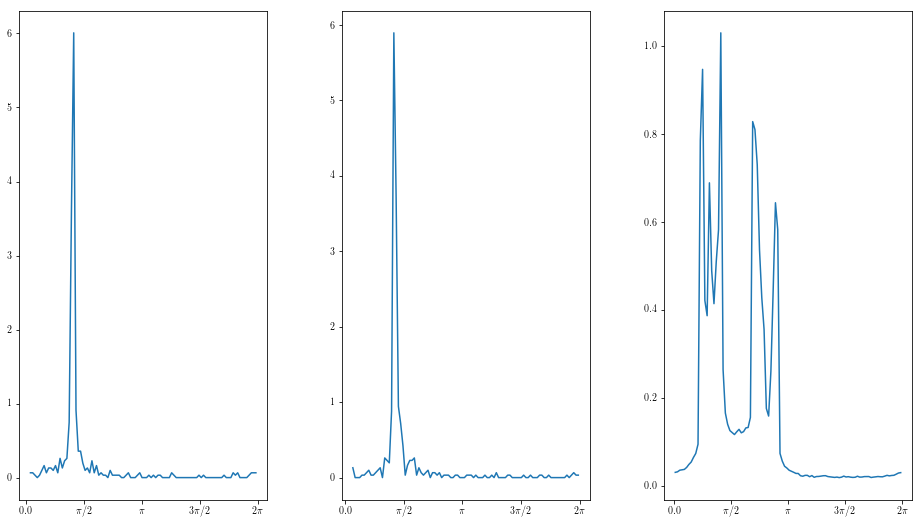

In [444]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
gs  = GridSpec(1, 3, hspace = 0.3, wspace = 0.3)  
ax1 = fig.add_subplot(gs[0, 0])

k_triads = extract_triads_k(triads, 22, kmin, kmax, False)

counts, bins = np.histogram(k_triads, bins = 100, density = True)
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)
ax1.set_xticks([0.0, np.pi/2, np.pi, 3.0 * np.pi / 2, 2.0 * np.pi])
ax1.set_xticklabels([r"$0.0$", r"$\pi / 2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
# ax1.set_yscale('log')

ax2 = fig.add_subplot(gs[0, 1])
k_triads = extract_triads_k(triads, 13, kmin, kmax, False)
counts, bins = np.histogram(k_triads, bins = 100, density = True)
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax2.plot(bin_centres, counts)
ax2.set_xticks([0.0, np.pi/2, np.pi, 3.0 * np.pi / 2, 2.0 * np.pi])
ax2.set_xticklabels([r"$0.0$", r"$\pi / 2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])

ax3 = fig.add_subplot(gs[0, 2])
# k_triads = extract_triads_k(triads, 13, kmin, kmax)
counts, bins = np.histogram(k_triads_all, bins = 100, density = True)
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax3.plot(bin_centres, counts)
ax3.set_xticks([0.0, np.pi/2, np.pi, 3.0 * np.pi / 2, 2.0 * np.pi])
ax3.set_xticklabels([r"$0.0$", r"$\pi / 2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
plt.show()

In [40]:
@njit
def compute_all_triads_all(phases, kmin, kmax):
    
    triads_non_ordered = np.ones((kmax + 1, 2 * kmax + 1, phases.shape[0])) * (-10.0)

    for t in range(phases.shape[0]):
        for k in range(kmin, kmax + 1):
            for k1 in range(-kmax + k, kmax + 1):
                if k - k1 <= -kmin:
                    if k1 <= -kmin and k1 >= -kmax:
                        triads_non_ordered[k, k1 - (-kmax), t] = -phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k]
                    if k1 >=  kmin and k1 <= kmax:
                        triads_non_ordered[k, k1 - (-kmax), t] = phases[t, k1] - phases[t, np.absolute(k - k1)] - phases[t, k]
                elif k - k1 >= kmin:
                    if k1 <= -kmin and k1 >= -kmax:
                        triads_non_ordered[k, k1 - (-kmax), t] = -phases[t, np.absolute(k1)] + phases[t, k - k1] - phases[t, k]
                    if k1 >=  kmin and k1 <= kmax:
                        triads_non_ordered[k, k1 - (-kmax), t] = phases[t, k1] + phases[t, k - k1] - phases[t, k]       
                        
    return triads_non_ordered

@njit
def compute_all_triads_current(phases, kmin, kmax, t_star):
        
    triads_non_ordered = np.ones((kmax + 1, 2 * kmax + 1)) * (-10.0)

    for k in range(kmin, kmax + 1):
        for k1 in range(-kmax + k, kmax + 1):
            if k - k1 <= -kmin:
                if k1 <= -kmin and k1 >= -kmax:
                    triads_non_ordered[k, k1 - (-kmax)] = -phases[t_star, np.absolute(k1)] - phases[t_star, np.absolute(k - k1)] - phases[t_star, k]
                if k1 >=  kmin and k1 <= kmax:
                    triads_non_ordered[k, k1 - (-kmax)] = phases[t_star, k1] - phases[t_star, np.absolute(k - k1)] - phases[t_star, k]
            elif k - k1 >= kmin:
                if k1 <= -kmin and k1 >= -kmax:
                    triads_non_ordered[k, k1 - (-kmax)] = -phases[t_star, np.absolute(k1)] + phases[t_star, k - k1] - phases[t_star, k]
                if k1 >=  kmin and k1 <= kmax:
                    triads_non_ordered[k, k1 - (-kmax)] = phases[t_star, k1] + phases[t_star, k - k1] - phases[t_star, k]                    
    
    return triads_non_ordered


def extract_all_triads_all_k(phases, k_star, kmin, kmax, t_star, full = False):
    
    triads_non_ordered_k = list()
    
    if full == True:
        for t in range(phases.shape[0]):
            for k in range(kmin, kmax + 1):
                for k1 in range(-kmax + k, kmax + 1):

                    if (k == k_star) or (np.absolute(k1) == k_star) or (np.absolute(k - k1) == k_star):
                        if k - k1 <= -kmin:
                            if k1 <= -kmin and k1 >= -kmax:
                                triads_non_ordered_k.append(-phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k])
                            if k1 >=  kmin and k1 <= kmax:
                                triads_non_ordered_k.append(phases[t, k1] - phases[t, np.absolute(k - k1)] - phases[t, k])
                        elif k - k1 >= kmin:
                            if k1 <= -kmin and k1 >= -kmax:
                                triads_non_ordered_k.append(-phases[t, np.absolute(k1)] + phases[t, k - k1] - phases[t, k])
                            if k1 >=  kmin and k1 <= kmax:
                                triads_non_ordered_k.append(phases[t, k1] + phases[t, k - k1] - phases[t, k])
                    else:
                        continue
    else:
        for k in range(kmin, kmax + 1):
            for k1 in range(-kmax + k, kmax + 1):

                if (k == k_star) or (np.absolute(k1) == k_star) or (np.absolute(k - k1) == k_star):
                    if k - k1 <= -kmin:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_non_ordered_k.append(-phases[t_star, np.absolute(k1)] - phases[t_star, np.absolute(k - k1)] - phases[t_star, k])
                        if k1 >=  kmin and k1 <= kmax:
                            triads_non_ordered_k.append(phases[t_star, k1] - phases[t_star, np.absolute(k - k1)] - phases[t_star, k])
                    elif k - k1 >= kmin:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_non_ordered_k.append(-phases[t_star, np.absolute(k1)] + phases[t_star, k - k1] - phases[t_star, k])
                        if k1 >=  kmin and k1 <= kmax:
                            triads_non_ordered_k.append(phases[t_star, k1] + phases[t, k - k1] - phases[t, k])
                else:
                    continue
                   
    return triads_non_ordered_k

In [45]:
@njit
def compute_seperated_triads_all(phases, kmin, kmax):
    
    triads_non_ordered = np.ones((kmax + 1, 2 * kmax + 1, phases.shape[0])) * (-10.0)
    triads_ordered = np.ones((kmax + 1, 2 * kmax + 1, phases.shape[0])) * (-10.0)
    
    for t in range(phases.shape[0]):
        for k in range(kmin, kmax + 1):
            for k1 in range(-kmax + k, kmax + 1):
                if k > np.absolute(k1) and np.absolute(k - k1) >= np.absolute(k1):
                    if k - k1 <= -kmin and k - k1 >= -kmax:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_ordered[k, k1 - (-kmax), t] = -phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k]
                        elif k1 >= kmin and k1 <= kmax:
                            triads_ordered[k, k1 - (-kmax), t] = phases[t, k1] - phases[t, np.absolute(k - k1)] - phases[t, k]
                    elif k - k1 >= kmin and k - k1 <= kmax:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_ordered[k, k1 - (-kmax), t] = -phases[t, np.absolute(k1)] + phases[t, k - k1] - phases[t, k]
                        elif k1 >=  kmin and k1 <= kmax:
                            triads_ordered[k, k1 - (-kmax), t] = phases[t, k1] + phases[t, k - k1] - phases[t, k]
                else:
                    if k - k1 <= -kmin and k - k1 >= -kmax:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_non_ordered[k, k1 - (-kmax), t] = -phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k]
                        elif k1 >=  kmin and k1 <= kmax:
                            triads_non_ordered[k, k1 - (-kmax), t] = phases[t, k1] - phases[t, np.absolute(k - k1)] - phases[t, k]
                    elif k - k1 >= kmin and k - k1 <= kmax:
                        if k1 <= -kmin and k1 >= -kmax:
                            triads_non_ordered[k, k1 - (-kmax), t] = -phases[t, np.absolute(k1)] + phases[t, k - k1] - phases[t, k]
                        elif k1 >=  kmin and k1 <= kmax:
                            triads_non_ordered[k, k1 - (-kmax), t] = phases[t, k1] + phases[t, k - k1] - phases[t, k]   
                        
    return triads_non_ordered, triads_ordered

In [234]:
@njit
def ordered_sync_phase(phases, kmin, kmax):
    
    ordered_triads_sync_phase = np.ones(phases.shape) * np.complex(0.0, 0.0)
    triad = np.complex(0.0, 0.0)
    
    for t in range(phases.shape[0]):
        for k in range(kmin, kmax + 1):
            triad = np.complex(0.0, 0.0)
            for k1 in range(-kmax + k, kmax + 1):
                if np.absolute(k1) >= kmin and np.absolute(k - k1) >= kmin:
                    triad += amps[np.absolute(k1)] * amps[np.absolute(k - k1)] * np.exp(np.complex(0.0, 1.0) *  (np.sign(k - k1) * phases[t, np.absolute(k1)] + np.sign(k1) * phases[t, np.absolute(k - k1)] - np.sign(k1 * (k - k1)) * phases[t, k]))
            ordered_triads_sync_phase[t, k] = np.complex(0.0, 1.0) * triad

    return ordered_triads_sync_phase

In [235]:
%%time 
orderedtriads_sync_phase = ordered_sync_phase(phases, kmin, kmax)

CPU times: user 12.7 s, sys: 97.2 ms, total: 12.8 s
Wall time: 12.8 s


In [46]:
%%time
all_triads = compute_non_odered_triads_all(phases, kmin, kmax)

CPU times: user 4min 42s, sys: 58.2 s, total: 5min 40s
Wall time: 5min 37s


In [47]:
%%time
triads_non_ordered, triads_ordered = compute_seperated_triads_all(phases, kmin, kmax)

CPU times: user 5min 41s, sys: 1min 50s, total: 7min 32s
Wall time: 7min 30s


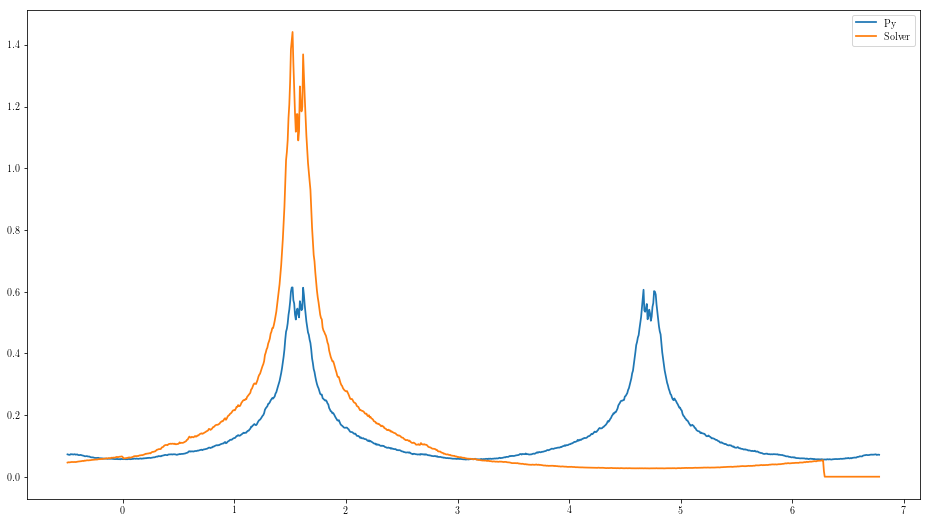

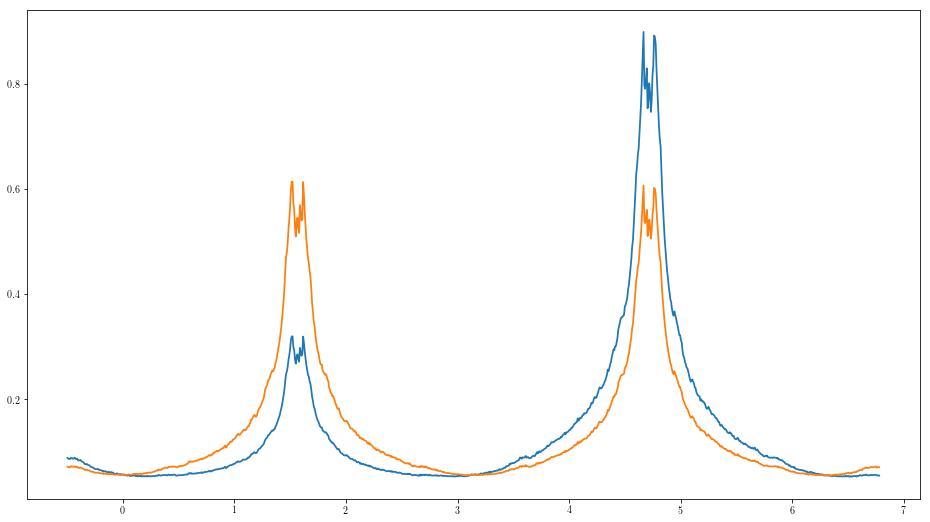

In [48]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
gs  = GridSpec(1, 1, hspace = 0.3, wspace = 0.3)  
ax1 = fig.add_subplot(gs[0, 0])

counts, bins = np.histogram(np.extract(triads_ordered != -10.0, triads_ordered), bins = 1000, density = True, range = (0.0 - 0.5, 2.0 * np.pi + 0.5))
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)
counts, bins = np.histogram(np.extract(triads_solver != -10.0, triads_solver), bins = 1000, density = True, range = (0.0 - 0.5, 2.0 * np.pi + 0.5))
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)
ax1.legend([r"Py", r"Solver"])

fig = plt.figure(figsize = (16, 9), tight_layout = False)
gs  = GridSpec(1, 1, hspace = 0.3, wspace = 0.3)  
ax1 = fig.add_subplot(gs[0, 0])
counts, bins = np.histogram(np.extract(triads_non_ordered != -10.0, triads_non_ordered), bins = 1000, density = True, range = (0.0 - 0.5, 2.0 * np.pi + 0.5))
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)
counts, bins = np.histogram(np.extract(triads_ordered != -10.0, triads_ordered), bins = 1000, density = True, range = (0.0 - 0.5, 2.0 * np.pi + 0.5))
bin_centres = (bins[1:] + bins[:-1]) * 0.5
ax1.plot(bin_centres, counts)
plt.show()

In [446]:
ordered_order = ordered_sync_phase(phases, kmin, kmax)
ordered_time_order = compute_time_order(ordered_order, kmin)

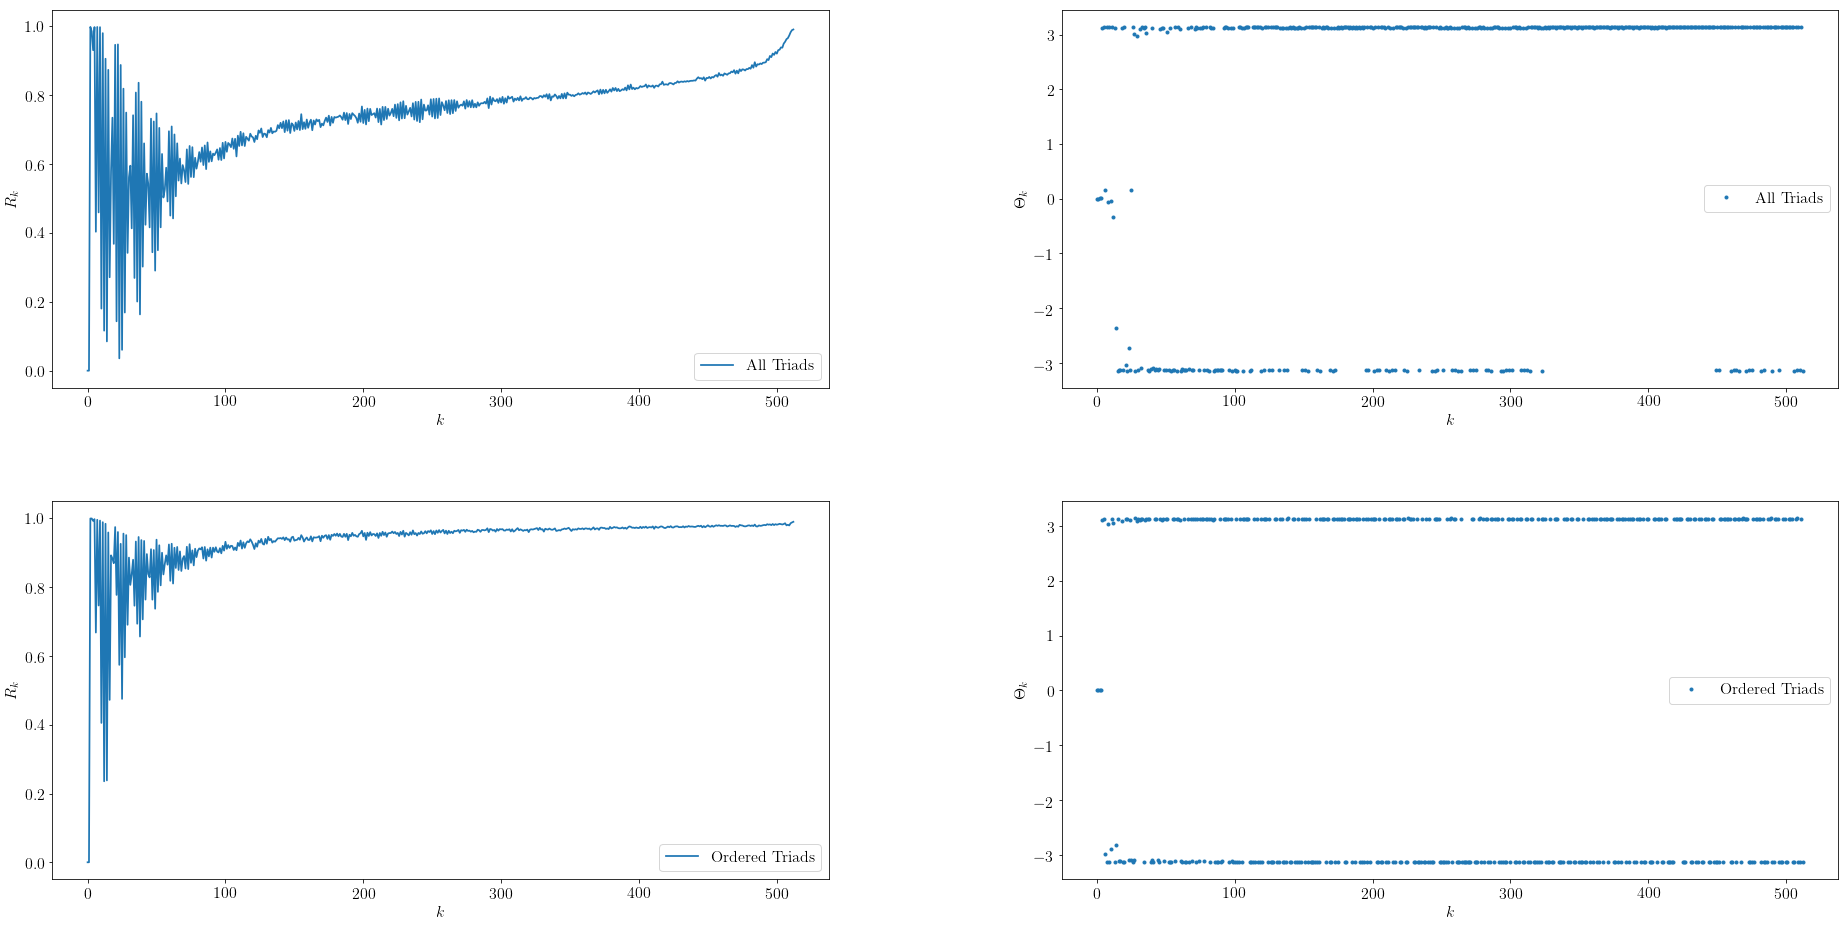

In [453]:
fig = plt.figure(figsize = (32, 16), tight_layout = False)
xg = 2
yg = 2
gs = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

ax[0].plot(np.absolute(time_order[-1, :]))
ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"$R_k$")
ax[0].legend(["All Triads"])

ax[1].plot(np.angle(time_order[-1, :]), '.')
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$\Theta_k$")
ax[1].legend(["All Triads"])

ax[2].plot(np.absolute(ordered_time_order[-1, :]))
ax[2].set_xlabel(r"$k$")
ax[2].set_ylabel(r"$R_k$")
ax[2].legend(["Ordered Triads"])

ax[3].plot(np.angle(ordered_time_order[-1, :]), '.')
ax[3].set_xlabel(r"$k$")
ax[3].set_ylabel(r"$\Theta_k$")
ax[3].legend(["Ordered Triads"])

# print(np.angle(ordered_time_order[-1, :]))
plt.show()
plt.close()

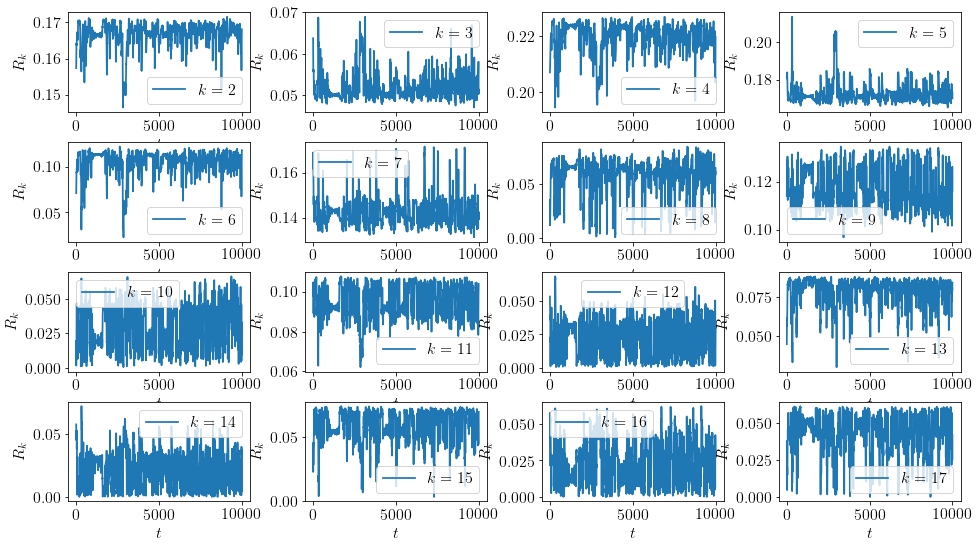

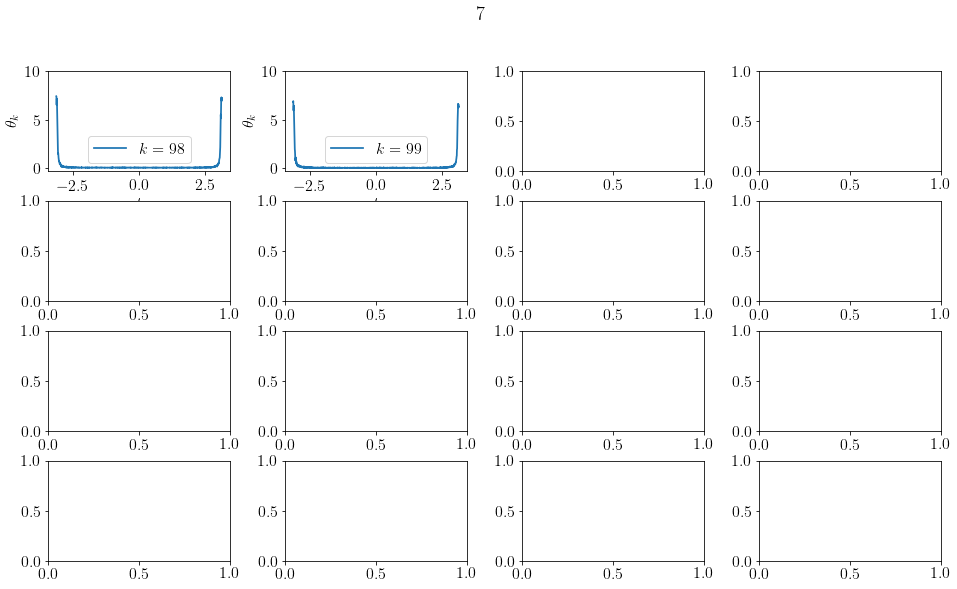

In [241]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 18)):    
    ax[count].plot(np.absolute(orderedtriads_sync_phase[:, k]))
#     ax[count].plot(np.absolute(normed_time_order[:, k]), '--')
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\tilda{R}_k$")
    ax[count].legend(["$k = {}$".format(k)])
#     ax[count].set_yscale('log')
#     ax[count].set_ylim(0, 1)
#     ax[count].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
#     ax[count].set_yticklabels([r"$-\pi$", r"$- \frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
    
#     if count == 15:
#         plt.savefig(output_dir + "/Rtilda_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
#         for i in range(xg * yg):
#             ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)

fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j])) 
count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 100)):    
    
    
#     ax[count].plot(np.unwrap(np.angle(orderedtriads_sync_phase[:, k])))
    counts, bins = np.histogram(np.angle(orderedtriads_sync_phase[:, k]), bins = 1000, density = False)
    bin_cents = (bins[1:] + bins[:-1]) * 0.5
    pdf = counts / (np.sum(counts) * (bins[1] - bins[0]))
    ax[count].plot(bin_cents, pdf)
#     ax[count].plot(np.mod(np.angle(orderedtriads_sync_phase[:, k]) + np.pi/2, 2.0 * np.pi) - np.pi/2)
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\theta_k$")
    ax[count].legend(["$k = {}$".format(k)])
    ax[count].set_ylim(top = 10)
#     ax[count].set_ylim(-np.pi/2-0.25, 3.0*np.pi/2 + 0.25)
#     ax[count].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
#     ax[count].set_yticklabels([r"$-\pi$", r"$- \frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
    
    if count == 15:
        plt.savefig(output_dir + "/THETA_K_ORDERED_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
        for i in range(xg * yg):
            ax[i].cla()
        plot += 1
        
    plt.suptitle(r"{}".format(plot))
    
    count += 1
    count = np.mod(count, 16)
plt.show()
plt.close()

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


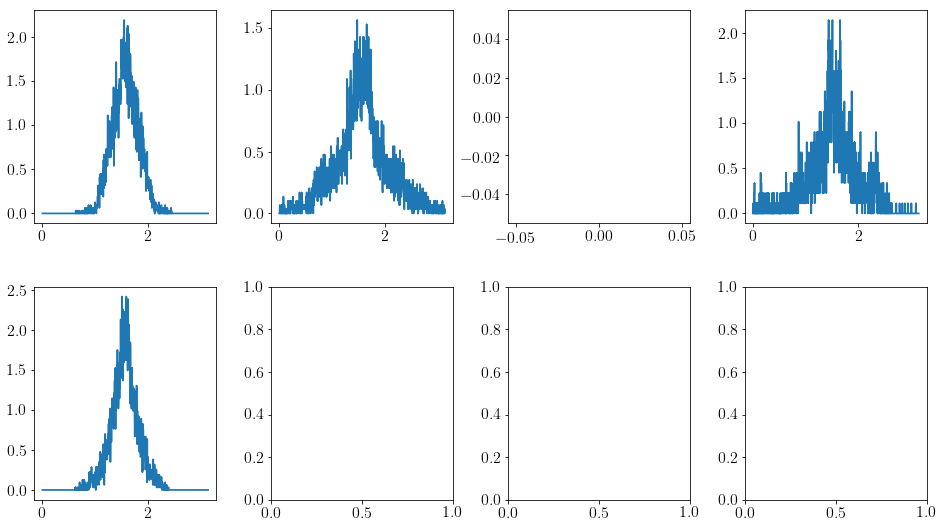

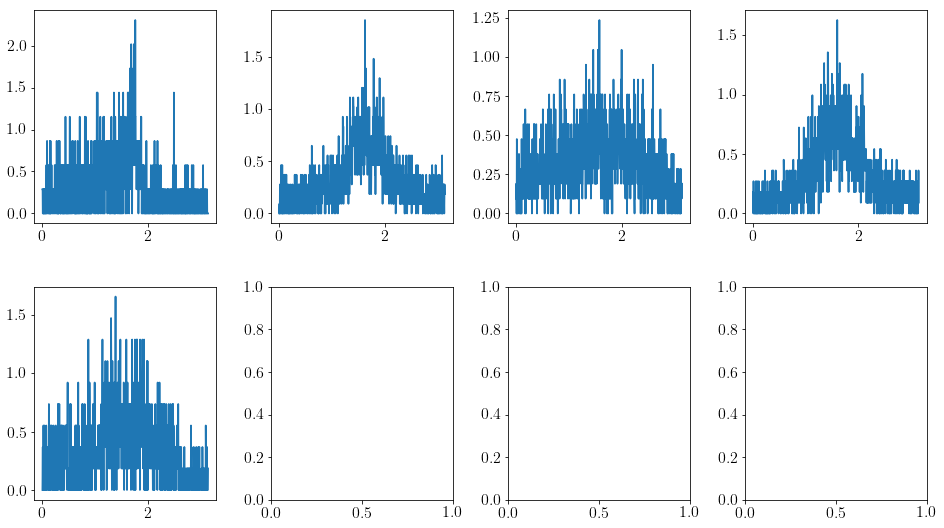

In [271]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 2
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j])) 
count = 0
plot = 1

for i, k in enumerate(range(0, 16)):
#     if count >= 15:
#         continue
#     else:
    if triads_solver[0, 11, k] == -10.0:
        continue
    else:
        counts, bins = np.histogram(triads_solver[:, 11, k], bins = 1000, density = False, range = (0.0, np.pi))
        bin_cents = (bins[1:] + bins[:-1]) * 0.5
        pdf = counts / (np.sum(counts * (bins[1] - bins[0])))
        ax[i].plot(bin_cents, pdf)
        count += 1
            
fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 2
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j])) 
count = 0
plot = 1

for i, k in enumerate(range(0, 16)):
#     if count >= 15:
#         continue
#     else:
    if triads_solver[0, 11, k] == -10.0:
        continue
    else:
        counts, bins = np.histogram(triads_solver[:, 12, k], bins = 1000, density = False, range = (0.0, np.pi))
        bin_cents = (bins[1:] + bins[:-1]) * 0.5
        pdf = counts / (np.sum(counts * (bins[1] - bins[0])))
        ax[i].plot(bin_cents, pdf)
#     count += 1
    
plt.show()

In [317]:
# print(triads_solver[:100, 11, :16])

kkmin = 2
kkmax = 6
pp = np.ones((kkmax + 1)) * np.pi / 4
pp[:kkmin] = 0
# print(pp)
order = np.ones((kkmax + 1)) * np.complex(0.0, 0.0)
for k in range(kkmin, kkmax + 1):
#     triad = np.complex(0.0, 0.0)
    for k1 in range(-kkmax + k, kkmax + 1):
        if np.absolute(k1) >= kmin and np.absolute(k - k1) >= kmin:
#             print("({}, {}, {})".format(k1, k -k1, -k), end = "")
            print("({}, {}, {})".format(np.sign(k1) * np.absolute(k1), np.sign(k - k1) * np.absolute(k - k1),  -k), end = "")
#             print("({}, {}, {})".format(np.sign(k - k1) * np.absolute(k1), np.sign(k1) * np.absolute(k - k1), - np.sign(k1 * (k - k1)) * np.absolute(k)), end = "")
#             order[k] +=  np.exp(np.complex(0.0, 1.0) * (np.sign(k - k1) * pp[np.absolute(k1)] + np.sign(k1) * pp[np.absolute(k - k1)] - np.sign(k1 * (k - k1)) * pp[np.absolute(k)])) 
            order[k] += amps[np.absolute(k1)] * amps[np.absolute(k - k1)] * np.exp(np.complex(0.0, 1.0) * (np.sign(k1) * pp[np.absolute(k1)] + np.sign(k - k1) * pp[np.absolute(k - k1)] - pp[k])) 
    
    order[k] *= np.complex(0.0, 1.0)
    print()

print()
print()
for k in range(kkmax + 1):
    print("{} {}I".format(np.real(order[k]), np.imag(order[k])))
    

(-4, 6, -2)(-3, 5, -2)(-2, 4, -2)(4, -2, -2)(5, -3, -2)(6, -4, -2)
(-3, 6, -3)(-2, 5, -3)(5, -2, -3)(6, -3, -3)
(-2, 6, -4)(2, 2, -4)(6, -2, -4)
(2, 3, -5)(3, 2, -5)
(2, 4, -6)(3, 3, -6)(4, 2, -6)


0.0 0.0I
0.0 0.0I
0.09887135538612457 0.0988713553861246I
0.0632398780685143 0.06323987806851432I
-0.05436765677632986 0.12240903852030705I
-0.09622504486493764 0.09622504486493766I
-0.08868914004394621 0.08868914004394624I


In [103]:
kkmin = 10
kkmax = 56
for k in range(kkmin, kkmax + 1):
    triad = np.complex(0.0, 0.0)
    for k1 in range(-kkmax + k, kkmax + 1):
        if np.absolute(k1) >= kkmin and np.absolute(k - k1) >= kkmin:
            triad += amps[np.absolute(k1)] * amps[np.absolute(k - k1)] * np.exp(np.complex(0.0, 1.0) * np.sign(k1 * (k - k1)) * (np.pi / 2 + np.pi/2 - np.pi/2))
    print(np.complex(0.0, 1.0) * triad)
        
        
        
        
#         if np.absolute(k1) >= kkmin and np.absolute(k - k1) >= kkmin:
#             if k1 >= kkmin and k1 <= int(k/2):
# #                 print("({})ORDERED({}, {}, {})".format(np.sign(k1 * (k - k1)), k1, k - k1, k), end = " ")
#                 print("ORDERED({}, {}, {})".format(k1, k - k1, k), end = " ")
#             else:                
# #                 print("({})({}, {}, {})".format(np.sign(k1 * (k - k1)), k1, k - k1, k), end = " ")
#                 print("({}, {}, {})".format(k1, k - k1, k), end = " ")
#     print()

(0.004839910078487351+2.963590192890276e-19j)
(0.004554649639548524+2.7889185511553723e-19j)
(0.004294618329547497+2.6296952954199487e-19j)
(0.00405647888532631+2.4838769413618437e-19j)
(0.0038374388327891977+2.3497535917495237e-19j)
(0.003635142235094318+2.2258826513268064e-19j)
(0.003447586064193766+2.111037619149958e-19j)
(0.0032730548649784245+2.0041680819147502e-19j)
(0.0031100691712032985+1.9043681278204907e-19j)
(0.0029573443707593037+1.8108511588134117e-19j)
(0.0018137575871333192+2.335253010903375e-19j)
(0.00094475241802566+2.701502936045217e-19j)
(0.00027739222005381014+2.953189782356741e-19j)
(-0.0002396000368848235+3.120755353620619e-19j)
(-0.0006430225680414993+3.2258726095683134e-19j)
(-0.0009597546074694321+3.2842218529347297e-19j)
(-0.0012097366543290685+3.307301943112194e-19j)
(-0.0014079670741292977+3.303640941928099e-19j)
(-0.0015658688111631818+3.279622384800497e-19j)
(-0.0016922428980536486+3.240059497430872e-19j)
(-0.001793945158597812+3.188600551702261e-19j)
(-0.

In [160]:
@njit
def heaviside_alltriads_phase(phases, kmin, kmax):
    triad_order = np.ones(phases.shape) * np.complex(0.0, 0.0)
    triad = np.complex(0.0, 0.0)

    for t in range(phases.shape[0]):
        for k in range(kmin, kmax + 1):
            triad = np.complex(0.0, 0.0)
            for k1 in range(-kmax + k, kmax + 1):
                if np.absolute(k1) >= kmin and np.absolute(k - k1) >= kmin:
                    if k1 < 0 and k - k1 > 0:
                        triad += np.exp(np.complex(0.0, 1.0) * (-phases[t, np.absolute(k1)] + phases[t, np.absolute(k - k1)] - phases[t, k]))
                    if k1 > 0 and k - k1 < 0:
                        triad += np.exp(np.complex(0.0, 1.0) * (phases[t, np.absolute(k1)] - phases[t, np.absolute(k - k1)] - phases[t, k]))
                    elif k1 > 0 and k - k1 > 0:
                        triad += np.exp(np.complex(0.0, 1.0) * (phases[t, np.absolute(k1)] + phases[t, k - k1] - phases[t, k]))

            triad_order[t, k] = np.complex(0.0, 1.0) * triad

    return triad_order


@njit
def heaviside_orderedtriads_phase(phases, kmin, kmax):
    triad_order = np.ones(phases.shape) * np.complex(0.0, 0.0)
    triad = np.complex(0.0, 0.0)

    for t in range(phases.shape[0]):
        for k in range(kmin, kmax + 1):
            triad = np.complex(0.0, 0.0)
            for k1 in range(-kmax + k, kmax + 1):
                if np.absolute(k1) >= kmin and np.absolute(k - k1) >= kmin:
                    triad += np.exp(np.complex(0.0, 1.0) * np.sign(k1 * (k - k1)) * (phases[t, k1] + phases[t, k - k1] - phases[t, k]))

            triad_order[t, k] = np.complex(0.0, 1.0) * triad

    return triad_order

In [161]:
## Compute the heavside version of the sync phase
heaviside_all_order = heaviside_alltriads_phase(phases, kmin, kmax)

## Compute the time order parameter for the ordered triads
heaviside_all_time_order = compute_time_order(heaviside_all_order, kmin)
# print("Time Order")


## Compute the heaviside version using ordered triads
heaviside_ordered_order = heaviside_orderedtriads_phase(phases, kmin, kmax)

## Compute the time order parameter for the ordered triads
heaviside_ordered_time_order = compute_time_order(heaviside_ordered_order, kmin)
# print("Time Order")

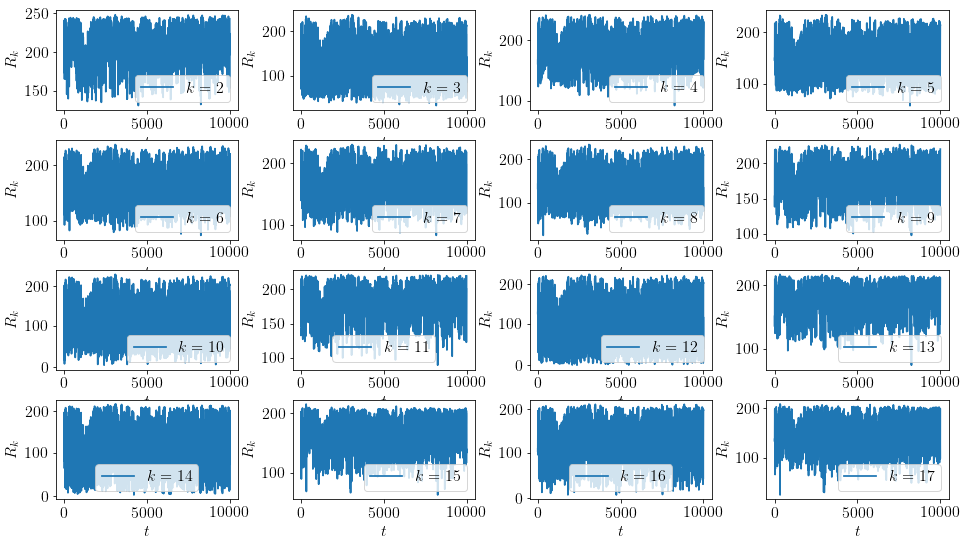

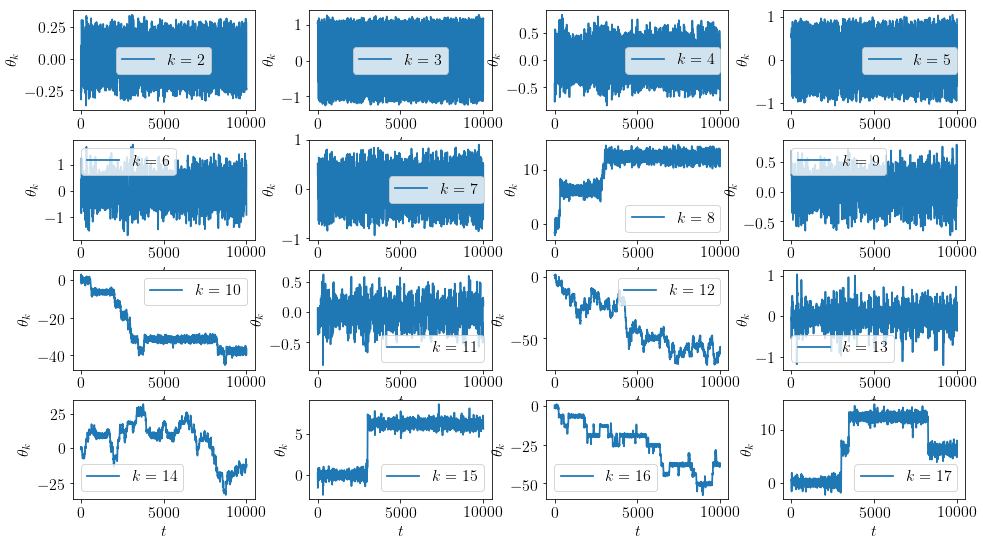

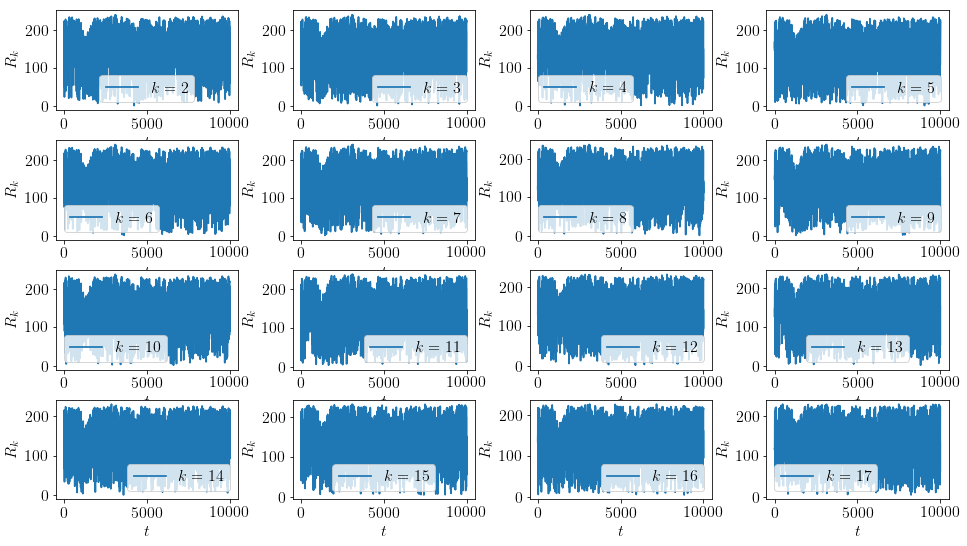

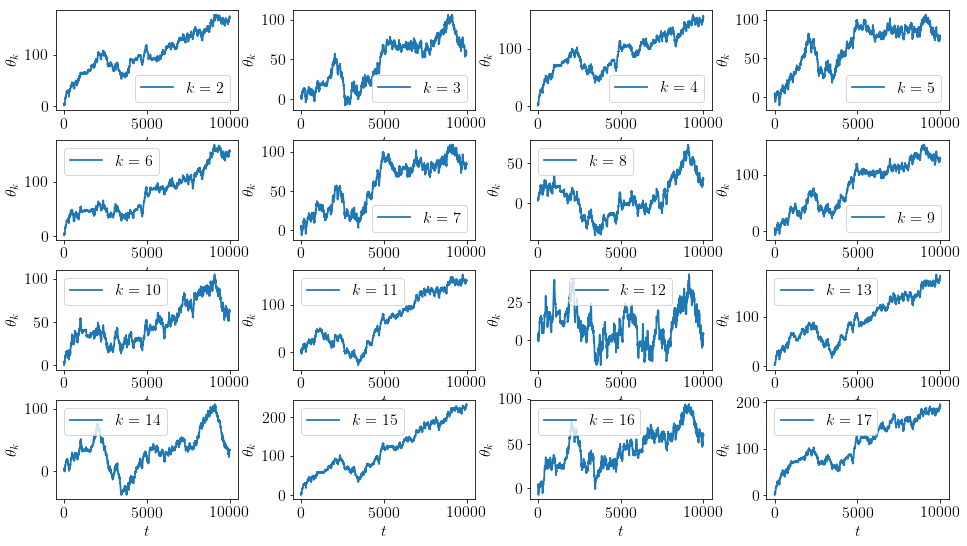

In [175]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 18)):    
    ax[count].plot(np.absolute(heaviside_all_order[:, k]))
#     ax[count].plot(np.absolute(normed_time_order[:, k]), '--')
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\tilda{R}_k$")
    ax[count].legend(["$k = {}$".format(k)])
#     if count == 15:
#         plt.savefig(output_dir + "/Rtilda_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
#         for i in range(xg * yg):
#             ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)

fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j])) 
count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 18)):    
    ax[count].plot(np.unwrap(np.angle(heaviside_all_order[:, k])))
#     ax[count].plot(np.mod(np.angle(order[:, k]) + np.pi/2, 2.0 * np.pi) - np.pi/2)
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\theta_k$")
    ax[count].legend(["$k = {}$".format(k)])
    
#     if count == 15:
#         plt.savefig(output_dir + "/THETA_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
#         for i in range(xg * yg):
#             ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)
plt.show()
plt.close()



fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 18)):    
    ax[count].plot(np.absolute(heaviside_ordered_order[:, k]))
#     ax[count].plot(np.absolute(normed_time_order[:, k]), '--')
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\tilda{R}_k$")
    ax[count].legend(["$k = {}$".format(k)])
#     if count == 15:
#         plt.savefig(output_dir + "/Rtilda_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
#         for i in range(xg * yg):
#             ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)

fig = plt.figure(figsize = (16, 9), tight_layout = False)
xg = 4
yg = 4
gs  = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j])) 
count = 0
plot = 1
for i, k in enumerate(range(k0 + 1, 18)):    
    ax[count].plot(np.unwrap(np.angle(heaviside_ordered_order[:, k])))
#     ax[count].plot(np.mod(np.angle(order[:, k]) + np.pi/2, 2.0 * np.pi) - np.pi/2)
    ax[count].set_xlabel(r"$t$")
    ax[count].set_ylabel(r"$\theta_k$")
    ax[count].legend(["$k = {}$".format(k)])
    
#     if count == 15:
#         plt.savefig(output_dir + "/THETA_K_k[{}]_N[VARIED]_ALPHA[VARIED]_BETA[{:0.3f}]_k0[{}]_ITERS[{}]_u0[{}]_test.png".format(plot, beta, k0, iters, u0), bbox_inches='tight')
#         for i in range(xg * yg):
#             ax[i].cla()
    
    plot += 1
    count += 1
    count = np.mod(count, 16)
plt.show()
plt.close()

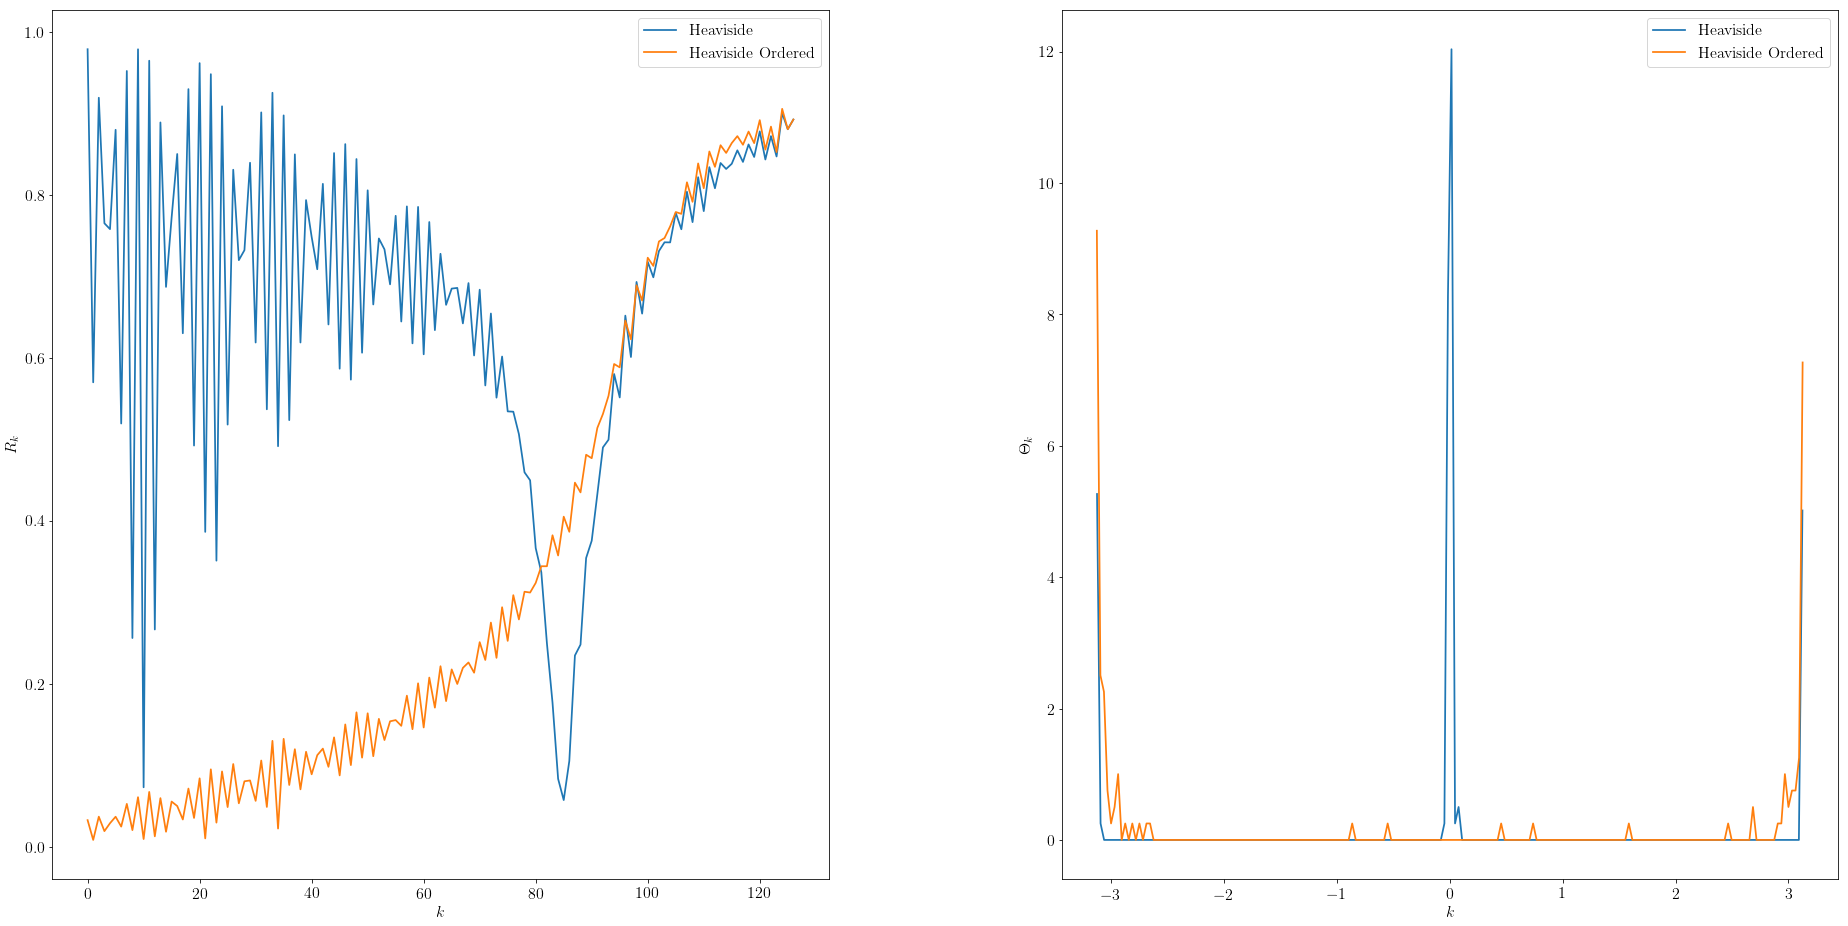

In [164]:
fig = plt.figure(figsize = (32, 16), tight_layout = False)
xg = 1
yg = 2
gs = GridSpec(xg, yg, hspace = 0.3, wspace = 0.3)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

# ax[0].plot(r_k)
# ax[0].plot(np.absolute(ordered_time_order[-1, :]))
ax[0].plot(np.absolute(heaviside_all_time_order[-1, k0 + 1:]))
ax[0].plot(np.absolute(heaviside_ordered_time_order[-1, k0 + 1:]))
ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"$R_k$")
ax[0].legend([r"Heaviside", r"Heaviside Ordered"])

# counts, bins = np.histogram(Theta_k, bins = 200, density = True)
# bin_centrs   = (bins[1:] + bins[:-1]) * 0.5
# ax[1].plot(bin_centrs, counts)
# counts, bins = np.histogram(np.angle(ordered_time_order[-1, :]), bins = 200, density = True)
# bin_centrs   = (bins[1:] + bins[:-1]) * 0.5
# ax[1].plot(bin_centrs, counts)
counts, bins = np.histogram(np.angle(heaviside_all_time_order[-1, k0 + 1:]), bins = 200, density = True)
bin_centrs   = (bins[1:] + bins[:-1]) * 0.5
ax[1].plot(bin_centrs, counts)
counts, bins = np.histogram(np.angle(heaviside_ordered_time_order[-1, k0 + 1:]), bins = 200, density = True)
bin_centrs   = (bins[1:] + bins[:-1]) * 0.5
ax[1].plot(bin_centrs, counts)
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$\Theta_k$")
ax[1].legend([r"Heaviside", r"Heaviside Ordered"])
plt.show()